In [41]:
import pandas as pd

# Read the CSV file into a DataFrame
import pandas as pd


df = pd.read_csv('k221.csv')
df1 = pd.read_csv('k300.csv')
df2 = pd.read_csv('k500.csv')
df3 = pd.read_csv('k800.csv')
df4 = pd.read_csv('k1000.csv')

## Check for Distribution Issue under t-closeness

The parameter t in t-closeness is a threshold that determines how close the distribution of a sensitive attribute within an equivalence class should be to the distribution of the same attribute in the overall dataset.

Earth Mover's Distance (EMD)
To measure the "distance" between the distributions, Earth Mover's Distance (EMD) is often used. EMD provides a way to quantify the difference between two probability distributions. The idea is to compute the minimum amount of "work" needed to transform one distribution into the other.

The Parameter 

Threshold 

t: This is the maximum acceptable distance (according to EMD) between the class distribution and the global distribution for the equivalence class to be considered t-close.

A smaller t means the distributions need to be more similar, enforcing stricter privacy.

A larger t allows more divergence between the distributions, providing more flexibility but potentially less privacy.

Maximum t-values for each sensitive attribute:
diag_1: 1.8920
diag_2: 1.5966
diag_3: 0.9000
max_glu_serum: 0.1343
A1Cresult: 0.2101
readmitted: 0.0618

Range of t-values for each sensitive attribute:
diag_1: Min t = 0.0674, Max t = 1.8920
diag_2: Min t = 0.0640, Max t = 1.5966
diag_3: Min t = 0.0420, Max t = 0.9000
max_glu_serum: Min t = 0.0034, Max t = 0.1343
A1Cresult: Min t = 0.0135, Max t = 0.2101
readmitted: Min t = 0.0004, Max t = 0.0618

Detailed t-values for each equivalence class and sensitive attribute:

diag_1:
  Class ('AfricanAmerican', 'Female', '[0-40)'): 0.9035
  Class ('AfricanAmerican', 'Female', '[40-50)'): 0.2039
  Class ('AfricanAmerican', 'Female', '[50-60)'): 0.1222
  Class ('AfricanAmerican', 'Female', '[60-70)'): 0.0674
  Class ('AfricanAmerican', 'Female', '[70-80)'): 0.1642
  Class ('AfricanAmerican', 'Female', '[80-100)'): 0.1245
  Class ('AfricanAmerican', 'Male', '[0-40)'): 0.7452
  Class ('AfricanAmerican', 'Male', '[40-50)'): 0.3705
  Class ('AfricanAmer

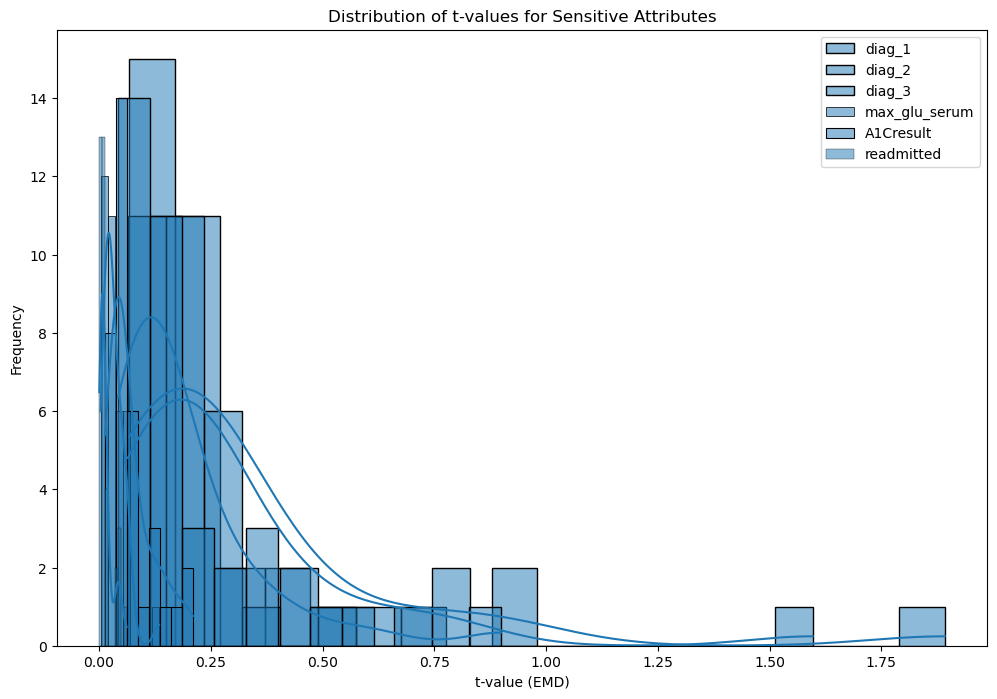

In [42]:
import pandas as pd
from scipy.stats import wasserstein_distance
import numpy as np

def calculate_distribution(series, all_categories=None):
    counts = series.value_counts(normalize=True)
    if all_categories is not None:
        counts = counts.reindex(all_categories, fill_value=0)
    return counts

def earth_mover_distance_numeric(p, q):
    return wasserstein_distance(p, q)

def earth_mover_distance_categorical(p, q):
    p, q = p.align(q, fill_value=0)
    categories = np.arange(len(p))
    return wasserstein_distance(categories, categories, p.values, q.values)

def calculate_t_closeness_emd(df, quasi_identifiers, sensitive_attribute, attribute_type='categorical'):
    global_distribution = calculate_distribution(df[sensitive_attribute])
    all_categories = global_distribution.index
    t_values = {}
    
    grouped = df.groupby(quasi_identifiers)
    for group_key, group_df in grouped:
        class_distribution = calculate_distribution(group_df[sensitive_attribute], all_categories)
        
        if attribute_type == 'numerical':
            emd = earth_mover_distance_numeric(global_distribution.values, class_distribution.values)
        else:
            emd = earth_mover_distance_categorical(global_distribution, class_distribution)
        
        t_values[group_key] = emd
    
    return t_values

def max_t_closeness_summary(df, quasi_identifiers, sensitive_attributes, attribute_types):
    max_t_values = {}
    detailed_t_values = {}
    range_t_values = {}
    
    for sensitive_attribute, attribute_type in zip(sensitive_attributes, attribute_types):
        t_values = calculate_t_closeness_emd(df, quasi_identifiers, sensitive_attribute, attribute_type)
        detailed_t_values[sensitive_attribute] = t_values
        
        if t_values:
            max_t_values[sensitive_attribute] = max(t_values.values())
            range_t_values[sensitive_attribute] = (min(t_values.values()), max(t_values.values()))
        else:
            max_t_values[sensitive_attribute] = 0.0
            range_t_values[sensitive_attribute] = (0.0, 0.0)
    
    return max_t_values, detailed_t_values, range_t_values



# Example usage
quasi_identifiers = ['race', 'gender', 'age']
sensitive_attributes = ['diag_1', 'diag_2', 'diag_3', 'max_glu_serum', 'A1Cresult', 'readmitted']
attribute_types = ['categorical', 'categorical', 'categorical', 'categorical', 'categorical', 'categorical']

# Calculate the maximum t-values for the sensitive attributes and the detailed t-values for each equivalence class
max_t_values, detailed_t_values, range_t_values = max_t_closeness_summary(df, quasi_identifiers, sensitive_attributes, attribute_types)

# Print the summary
print("Maximum t-values for each sensitive attribute:")
for attr, max_t in max_t_values.items():
    print(f"{attr}: {max_t:.4f}")

print("\nRange of t-values for each sensitive attribute:")
for attr, t_range in range_t_values.items():
    print(f"{attr}: Min t = {t_range[0]:.4f}, Max t = {t_range[1]:.4f}")

print("\nDetailed t-values for each equivalence class and sensitive attribute:")
for attr, class_t_values in detailed_t_values.items():
    print(f"\n{attr}:")
    for class_key, t_value in class_t_values.items():
        print(f"  Class {class_key}: {t_value:.4f}")

# Example decision process for tuning t
t_values_df = pd.DataFrame(detailed_t_values)
print("\nT-values DataFrame:\n", t_values_df)

# Plotting the distribution of t-values for each sensitive attribute
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 8))
for attr in sensitive_attributes:
    sns.histplot(t_values_df[attr].dropna(), kde=True, label=attr)

plt.xlabel('t-value (EMD)')
plt.ylabel('Frequency')
plt.title('Distribution of t-values for Sensitive Attributes')
plt.legend()
plt.show()


t = 0.25: Data Loss = 19.88%
t = 0.5: Data Loss = 6.51%
t = 0.75: Data Loss = 3.70%
t = 1: Data Loss = 0.32%


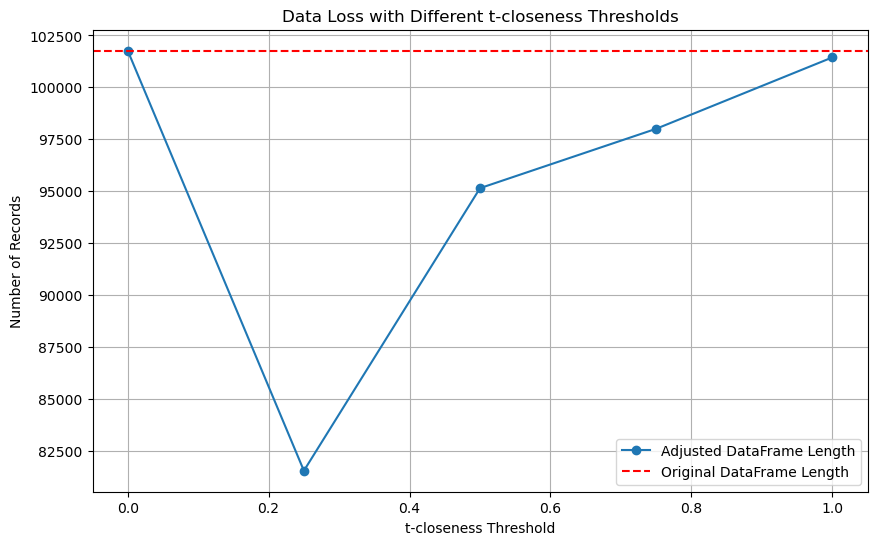

In [43]:
import pandas as pd
from scipy.stats import wasserstein_distance
import numpy as np
import matplotlib.pyplot as plt

def calculate_distribution(series, all_categories=None):
    counts = series.value_counts(normalize=True)
    if all_categories is not None:
        counts = counts.reindex(all_categories, fill_value=0)
    return counts

def earth_mover_distance_numeric(p, q):
    return wasserstein_distance(p, q)

def earth_mover_distance_categorical(p, q):
    p, q = p.align(q, fill_value=0)
    categories = np.arange(len(p))
    return wasserstein_distance(categories, categories, p.values, q.values)

def calculate_t_closeness_emd(df, quasi_identifiers, sensitive_attribute, attribute_type='categorical'):
    global_distribution = calculate_distribution(df[sensitive_attribute])
    all_categories = global_distribution.index
    t_values = {}
    
    grouped = df.groupby(quasi_identifiers)
    for group_key, group_df in grouped:
        class_distribution = calculate_distribution(group_df[sensitive_attribute], all_categories)
        
        if attribute_type == 'numerical':
            emd = earth_mover_distance_numeric(global_distribution.values, class_distribution.values)
        else:
            emd = earth_mover_distance_categorical(global_distribution, class_distribution)
        
        t_values[group_key] = emd
    
    return t_values, global_distribution, all_categories

def adjust_to_t_closeness(df, quasi_identifiers, sensitive_attributes, attribute_types, t):
    adjusted_df = df.copy()
    original_len = len(adjusted_df)
    
    for sensitive_attribute, attribute_type in zip(sensitive_attributes, attribute_types):
        t_values, global_distribution, all_categories = calculate_t_closeness_emd(adjusted_df, quasi_identifiers, sensitive_attribute, attribute_type)
        
        for group_key, emd in t_values.items():
            while emd > t:
                try:
                    group_df = adjusted_df.groupby(quasi_identifiers).get_group(group_key)
                    if group_df.empty:
                        break
                    if attribute_type == 'categorical':
                        most_common_value = group_df[sensitive_attribute].mode()[0]
                        rows_to_delete = group_df[group_df[sensitive_attribute] == most_common_value].index
                        adjusted_df = adjusted_df.drop(rows_to_delete)
                    elif attribute_type == 'numerical':
                        median_value = group_df[sensitive_attribute].median()
                        rows_to_delete = group_df[group_df[sensitive_attribute] == median_value].index
                        adjusted_df = adjusted_df.drop(rows_to_delete)
                    
                    group_df = adjusted_df.groupby(quasi_identifiers).get_group(group_key)
                    class_distribution = calculate_distribution(group_df[sensitive_attribute], all_categories)
                    if attribute_type == 'categorical':
                        emd = earth_mover_distance_categorical(global_distribution, class_distribution)
                    else:
                        emd = earth_mover_distance_numeric(global_distribution.values, class_distribution.values)
                
                except KeyError:
                    break
    
    data_loss = 1 - len(adjusted_df) / original_len
    return adjusted_df, data_loss


quasi_identifiers = ['race', 'gender', 'age']
sensitive_attributes = ['diag_1', 'diag_2', 'diag_3', 'max_glu_serum', 'A1Cresult', 'readmitted']
attribute_types = ['categorical', 'categorical', 'categorical', 'categorical', 'categorical', 'categorical']

# Range of t values to test
t_values = [0.25, 0.5, 0.75, 1]

# Store results
adjusted_dfs = []
data_losses = []

for t in t_values:
    # Adjust the dataset to satisfy t-closeness
    adjusted_df, data_loss = adjust_to_t_closeness(df, quasi_identifiers, sensitive_attributes, attribute_types, t)
    adjusted_dfs.append((t, adjusted_df))
    data_losses.append((t, data_loss))

# Print data loss
for t, data_loss in data_losses:
    print(f"t = {t}: Data Loss = {data_loss:.2%}")

# Plot the results
original_len = len(df)
adjusted_lengths = [len(adjusted_df) for _, adjusted_df in adjusted_dfs]

plt.figure(figsize=(10, 6))
plt.plot([0] + t_values, [original_len] + adjusted_lengths, marker='o', label='Adjusted DataFrame Length')
plt.axhline(y=original_len, color='r', linestyle='--', label='Original DataFrame Length')
plt.xlabel('t-closeness Threshold')
plt.ylabel('Number of Records')
plt.title('Data Loss with Different t-closeness Thresholds')
plt.legend()
plt.grid(True)
plt.show()
